# This notebook shows retrieve a model and data from an model dump file. 
The model is then simulated and the results are displayed. 

## The Economic Credit Loss model 
This jupyter notebook is inspired by IMF working paper (WP/20/111) The Expected Credit Loss Modeling from a Top-Down Stress Testing Perspective by Marco Gross, Dimitrios Laliotis, Mindaugas Leika, Pavel Lukyantsau. The working paper and the associated material is located https://www.imf.org/en/Publications/WP/Issues/2020/07/03/Expected-Credit-Loss-Modeling-from-a-Top-Down-Stress-Testing-Perspective-49545

from the abstract of the paper: 
> The objective of this paper is to present an integrated tool suite for IFRS 9- and CECL compatible
estimation in top-down solvency stress tests. The tool suite serves as an
illustration for institutions wishing to include accounting-based approaches for credit risk
modeling in top-down stress tests.

This is a jupyter notebook build with the purpose of illustrating the use of ModelFlow. The purpose is testing so take very much care.  

## Import libraries 

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from IPython.core.display import HTML,Markdown,Latex
from ipywidgets import interact,Dropdown,Checkbox



from modelclass import model
import modeljupytermagic
import modeljupyter as mj
from modelhelp import df_extend


# some useful stuf
model.widescreen()
pd.set_option('display.max_rows', None, 'display.max_columns', 10, 'display.precision', 2)
sortdf = lambda df: df[sorted([c for c in df.columns])]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fetch the precooked model and baseline 
The model and data has been specified in another Jupyter notebook: 

[file/Model for economic credit loss with Z score transition nynamic - setup]

In [4]:
ecl,baseline  = model.modelload('ecl.pcim')

## Input values for the adverse scenario

In [5]:
%%dataframe projection_adverse show
LOAN_GROWTH	M_S1	M_S2	WRO_S3	Z
0	1.00e-02	0.04	0.03	0.06	0.00
1	-1.00e-02	0.04	0.03	0.06	-0.65
2	-8.00e-03	0.04	0.03	0.06	-0.84
3	-6.00e-03	0.04	0.03	0.06	-0.99
4	-4.00e-03	0.04	0.03	0.06	-0.69
5	-2.00e-03	0.04	0.03	0.06	-0.39
6	-0.00e+00	0.04	0.03	0.06	-0.24

,LOAN_GROWTH,M_S1,M_S2,WRO_S3,Z
index,,,,,
2021,1.00e-02,0.04,0.03,0.06,0.00
2022,-1.00e-02,0.04,0.03,0.06,-0.65
2023,-8.00e-03,0.04,0.03,0.06,-0.84
2024,-6.00e-03,0.04,0.03,0.06,-0.99
2025,-4.00e-03,0.04,0.03,0.06,-0.69
2026,-2.00e-03,0.04,0.03,0.06,-0.39
2027,-0.00e+00,0.04,0.03,0.06,-0.24


## Create an adverse Dataframe

In [6]:
adverse = baseline.copy()
adverse.update(projection_adverse)

## Extend the data using the last observation to fill the extension periods

In [7]:
from modelhelp import df_extend
newbase = df_extend(baseline,10)
newadverse = df_extend(adverse,10)

## Run the ECL Model
For the Baseline and the adverse scenario 

In [8]:
base_result  = ecl(newbase,keep='Baseline',silent=1)
adverse_result = ecl(newadverse,keep = 'Adverse')

### Total loans 

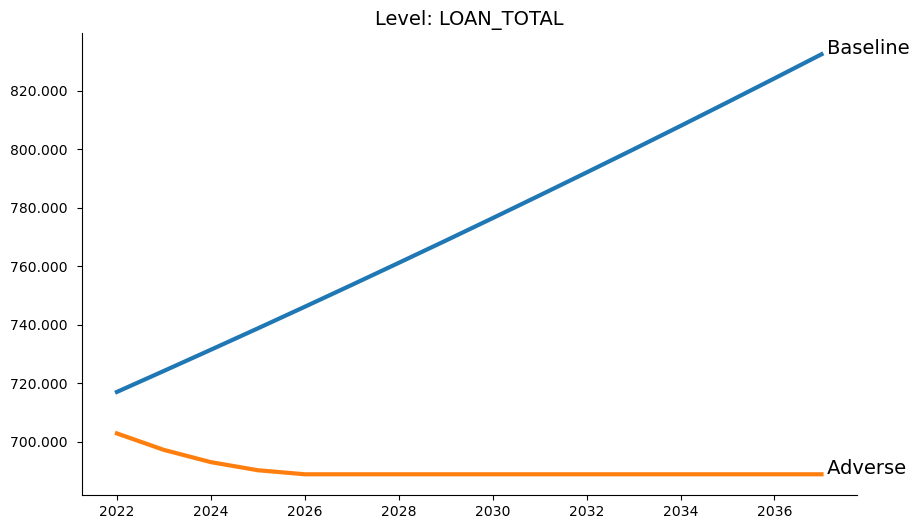

In [9]:
ecl.keep_plot('loan_total',showtype='level',legend=0);

### Loan portefolios in different stages

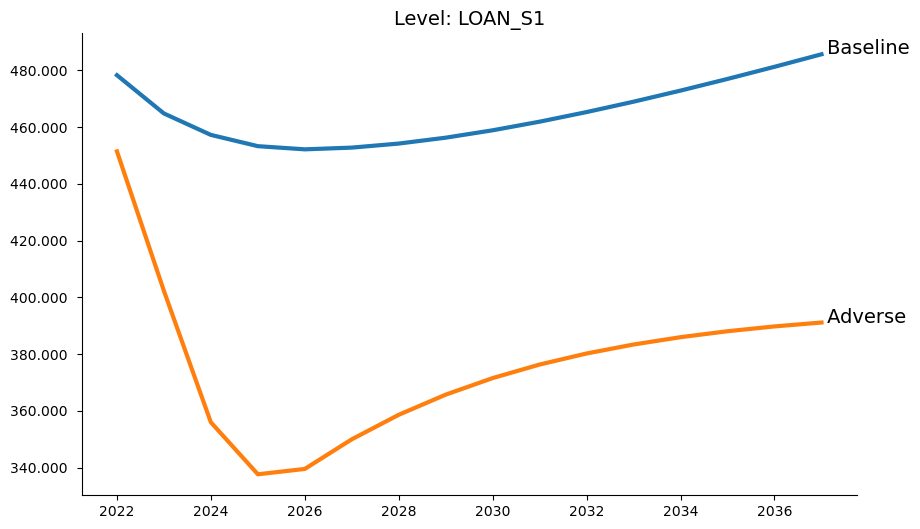

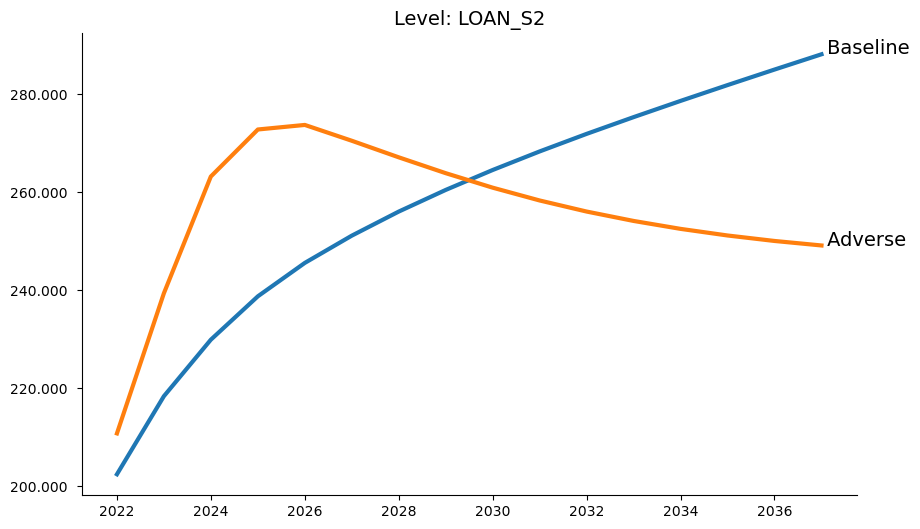

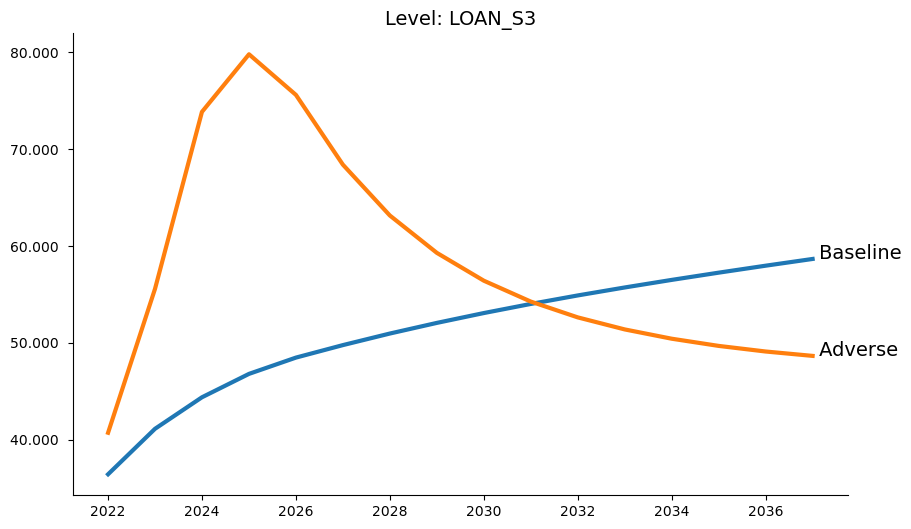

In [10]:
ecl.keep_plot('loaN_S?',showtype='level',legend=False);

## Create a long term loss model 

$
Repayment_t = \frac{100}{maturity} \in t=1,maturity
$

$
Notional_t = 100-\sum_{i=maturity-t-1}^{maturity}Repayment_t \in t=1,maturity
$

$
\underbrace{PD^{*}_s}_{\text{Incremental pd}} = PD_s\times \underbrace{\prod_{t=1}^{t=s-1}(1-PD_t)}_{\text{Surviving Non defaulted}}
$

$
ECL^{LT}_t=\sum_{s=t}^{Maturity+t}\underbrace{PD^{*}_s}_{\text{Incremental pd}}\times \underbrace{\frac{Notional_{s-1}+Notional_{s}}{2}}_{\text{Exposure if no defaults}} \times LGD_s \times \frac{1}{(1+r)^{s}}
$


$ECL_t=\sum_{s=t+1}^{t+M}\frac{TR^{2-3,*}_s \times LDG_s \times S2_{s-1}}{(1+r)^{s-t}}$

Just a reminder on provisioning 

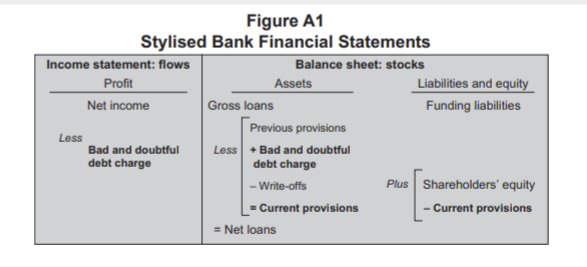
From : https://www.rba.gov.au/publications/fsr/2009/sep/pdf/box-a.pdf

In [11]:
%%latexflow accounting debug
### calculate value of  future loss 

the function: $lifetime\_credit\_loss(Maturity:int,discount\_rate:float,LGD:\text{float or np.array},PD: \text{float or np.array})$ will return the lifetime loss of a 
loan. The loan is assumet to amortize with equal instalment in each year of its maturity.

$LGD$ and $PD$ are the values in the future. If they are np.array's they should be longer
than the maturity.

In order to serve the future values to the $lifetime\_credit\_loss$ 
function the macro function: $lag\_array(lead,<variable>)$ will return an array of the lead 
future values of $variable$. If lead is negative it return an array of lagged values.  


In the Working Paper acompaning Excel sheets a maturity of 5 years is used. 

### Stage 1 losses 

For stage 2 we want the lifetime loss as  
the discounted value of the future loss . It is calculated like this (in percent): 

    
    
\begin{equation}
\label{eq:lt_loss_rate_s1}
lt\_loss\_rate\_s1 = lifetime\_credit\_loss(\underbrace{5}_{\text{Maturity}},
                                        \underbrace{0.01}_{\text{Discount rate}},
                                        \underbrace{0.20}_{\text{Future LGD}},
         \underbrace{lag\_array(6,TR\_s1\_s3)}_{\text{Default of Stage 1 loans next 6 years}})  
\end{equation}

And the actual lifetime loss on the loans in stage 2 can be calculated like this:

    
    
\begin{equation}
\label{eq:lt_loss_s1}
lt\_loss\_s1      = lt\_loss\_rate\_s1 * loan\_s1
\end{equation}

The Short time losses are the one year expected credit loss. This is 
calculated like this (in percent): 
    
\begin{equation}
\label{eq:st_loss_rate_s1}
st\_loss\_rate\_s1 = lifetime\_credit\_loss(\underbrace{1}_{\text{Only next year}},
                                        \underbrace{0.01}_{\text{Discount rate}},
                                        \underbrace{0.20}_{\text{Future LGD}},
         \underbrace{lag\_array(2,TR\_s1\_s3)}_{\text{Default of Stage 1 loans next 2 years}})  
\end{equation}


And the short time loss'es for  loans in stage 1 can be calculated like this:


\begin{equation}
\label{eq:st_loss_s1}
st\_loss\_s1      = st\_loss\_rate\_s2 * loan\_s2
\end{equation}


### Stage 2 losses 

For stage 2 we want the lifetime loss as  
the discounted value of the future loss . It is calculated like this (in percent): 

    
    
\begin{equation}
\label{eq:lt_loss_rate}
lt\_loss\_rate\_s2 = lifetime\_credit\_loss(\underbrace{5}_{\text{Maturity}},
                                        \underbrace{0.01}_{\text{Discount rate}},
                                        \underbrace{0.20}_{\text{Future LGD}},
         \underbrace{lag\_array(6,TR\_s2\_s3)}_{\text{Default of Stage 2 loans next 6 years}})  
\end{equation}

And the actual lifetime loss on the loans in stage 2 can be calculated like this:

    
    
\begin{equation}
\label{eq:lt_loss}
lt\_loss\_s2      = lt\_loss\_rate\_s2 * loan\_s2
\end{equation}

The Short time losses are the one year expected credit loss. This is 
calculated like this (in percent): 
    
\begin{equation}
\label{eq:st_loss_rate}
st\_loss\_rate\_s2 = lifetime\_credit\_loss(\underbrace{1}_{\text{Only next year}},
                                        \underbrace{0.01}_{\text{Discount rate}},
                                        \underbrace{0.20}_{\text{Future LGD}},
         \underbrace{lag\_array(2,TR\_s2\_s3)}_{\text{Default of Stage 2 loans next 2 years}})  
\end{equation}


And the IFRS9 on the loans in stage 1 can be calculated like this:


\begin{equation}
\label{eq:st_loss}
st\_loss\_s2      = st\_loss\_rate\_s2 * loan\_s2
\end{equation}


### Stage 3 losses

Here the losses are the loss given default (LGD) rate 

\begin{equation}
\label{eq:loss_rate_s3}
loss\_rate\_s3 =  \underbrace{0.20}_{\text{LGD}}  
\end{equation}

\begin{equation}
\label{eq:loss_s3}
loss\_s3      = loss\_rate\_s3 * loan\_s3
\end{equation}

In this exapmle the LGD is set to a fixed value. It couyld be a time serie but that will be implementet in 
one of the next iterations of the model. 

## Provisioning

Now provisioning according to the different accounting pricipes can be calculated 

We start with the IAS39 rules. Here provisioning is only the actual loss. This is the losses of the stage 3 loans. 

\begin{equation}
\label{eq:prov_ias39}
Provision\_stock\_IAS39 = loss\_s3
\end{equation}

Under the IFRS9 rules provisioning is the one short time loss (one year) loss on Stage 1 loans plus the long term 
loss on the stage 2 loans and the losses on the stage 3 loans. 

\begin{equation}
\label{eq:prov_ifrs9}
Provision\_stock\_ifrs9 = st\_loss\_s1 + lt\_loss\_s2 + loss\_s3  
\end{equation}


\begin{equation}
\label{eq:prov_cecl}
Provision\_stock\_cecl = lt\_loss\_s1 + lt\_loss\_s2 + loss\_s3  
\end{equation}

List $princip=\{ias38, ifrs9, cecl\}$


\begin{equation}
\label{eq:prov_flow}
Provision\_flow^{princip}= \Delta Provision\_stock^{princip} +
\underbrace{wro\_s3*lgd\_s3 * loan\_s3(-1)}_{\text{Adjustment to account for writeoff}}
\end{equation}



# Now creating the model **accounting**

# Creating this Template model

Frml lt_loss_rate_s1 lt_loss_rate_s1  = lifetime_credit_loss(5,0.01,0.20,lag_array(6,TR_s1_s3)) $ 
Frml lt_loss_s1 lt_loss_s1       = lt_loss_rate_s1*loan_s1 $ 
Frml st_loss_rate_s1 st_loss_rate_s1  = lifetime_credit_loss(1,0.01,0.20,lag_array(2,TR_s1_s3)) $ 
Frml st_loss_s1 st_loss_s1       = st_loss_rate_s2*loan_s2 $ 
Frml lt_loss_rate lt_loss_rate_s2  = lifetime_credit_loss(5,0.01,0.20,lag_array(6,TR_s2_s3)) $ 
Frml lt_loss lt_loss_s2       = lt_loss_rate_s2*loan_s2 $ 
Frml st_loss_rate st_loss_rate_s2  = lifetime_credit_loss(1,0.01,0.20,lag_array(2,TR_s2_s3)) $ 
Frml st_loss st_loss_s2       = st_loss_rate_s2*loan_s2 $ 
Frml loss_rate_s3 loss_rate_s3  = 0.20 $ 
Frml loss_s3 loss_s3       = loss_rate_s3*loan_s3 $ 
Frml prov_ias39 Provision_stock_IAS39  = loss_s3 $ 
Frml prov_ifrs9 Provision_stock_ifrs9  = st_loss_s1+lt_loss_s2+loss_s3 $ 
Frml prov_cecl Provision_stock_cecl  = lt_loss_s1+lt_loss_s2+loss_s3 $ 
Do princip $ 
 Frml prov_flow Provision_flow_{princip} = diff(Provision_sto

## The model

### calculate value of  future loss 

the function: $lifetime\_credit\_loss(Maturity:int,discount\_rate:float,LGD:\text{float or np.array},PD: \text{float or np.array})$ will return the lifetime loss of a 
loan. The loan is assumet to amortize with equal instalment in each year of its maturity.

$LGD$ and $PD$ are the values in the future. If they are np.array's they should be longer
than the maturity.

In order to serve the future values to the $lifetime\_credit\_loss$ 
function the macro function: $lag\_array(lead,<variable>)$ will return an array of the lead 
future values of $variable$. If lead is negative it return an array of lagged values.  


In the Working Paper acompaning Excel sheets a maturity of 5 years is used. 

### Stage 1 losses 

For stage 2 we want the lifetime loss as  
the discounted value of the future loss . It is calculated like this (in percent): 

    
    
\begin{equation}
\label{eq:lt_loss_rate_s1}
lt\_loss\_rate\_s1 = lifetime\_credit\_loss(\underbrace{5}_{\text{Maturity}},
                                        \underbrace{0.01}_{\text{Discount rate}},
                                        \underbrace{0.20}_{\text{Future LGD}},
         \underbrace{lag\_array(6,TR\_s1\_s3)}_{\text{Default of Stage 1 loans next 6 years}})  
\end{equation}

And the actual lifetime loss on the loans in stage 2 can be calculated like this:

    
    
\begin{equation}
\label{eq:lt_loss_s1}
lt\_loss\_s1      = lt\_loss\_rate\_s1 * loan\_s1
\end{equation}

The Short time losses are the one year expected credit loss. This is 
calculated like this (in percent): 
    
\begin{equation}
\label{eq:st_loss_rate_s1}
st\_loss\_rate\_s1 = lifetime\_credit\_loss(\underbrace{1}_{\text{Only next year}},
                                        \underbrace{0.01}_{\text{Discount rate}},
                                        \underbrace{0.20}_{\text{Future LGD}},
         \underbrace{lag\_array(2,TR\_s1\_s3)}_{\text{Default of Stage 1 loans next 2 years}})  
\end{equation}


And the short time loss'es for  loans in stage 1 can be calculated like this:


\begin{equation}
\label{eq:st_loss_s1}
st\_loss\_s1      = st\_loss\_rate\_s2 * loan\_s2
\end{equation}


### Stage 2 losses 

For stage 2 we want the lifetime loss as  
the discounted value of the future loss . It is calculated like this (in percent): 

    
    
\begin{equation}
\label{eq:lt_loss_rate}
lt\_loss\_rate\_s2 = lifetime\_credit\_loss(\underbrace{5}_{\text{Maturity}},
                                        \underbrace{0.01}_{\text{Discount rate}},
                                        \underbrace{0.20}_{\text{Future LGD}},
         \underbrace{lag\_array(6,TR\_s2\_s3)}_{\text{Default of Stage 2 loans next 6 years}})  
\end{equation}

And the actual lifetime loss on the loans in stage 2 can be calculated like this:

    
    
\begin{equation}
\label{eq:lt_loss}
lt\_loss\_s2      = lt\_loss\_rate\_s2 * loan\_s2
\end{equation}

The Short time losses are the one year expected credit loss. This is 
calculated like this (in percent): 
    
\begin{equation}
\label{eq:st_loss_rate}
st\_loss\_rate\_s2 = lifetime\_credit\_loss(\underbrace{1}_{\text{Only next year}},
                                        \underbrace{0.01}_{\text{Discount rate}},
                                        \underbrace{0.20}_{\text{Future LGD}},
         \underbrace{lag\_array(2,TR\_s2\_s3)}_{\text{Default of Stage 2 loans next 2 years}})  
\end{equation}


And the IFRS9 on the loans in stage 1 can be calculated like this:


\begin{equation}
\label{eq:st_loss}
st\_loss\_s2      = st\_loss\_rate\_s2 * loan\_s2
\end{equation}


### Stage 3 losses

Here the losses are the loss given default (LGD) rate 

\begin{equation}
\label{eq:loss_rate_s3}
loss\_rate\_s3 =  \underbrace{0.20}_{\text{LGD}}  
\end{equation}

\begin{equation}
\label{eq:loss_s3}
loss\_s3      = loss\_rate\_s3 * loan\_s3
\end{equation}

In this exapmle the LGD is set to a fixed value. It couyld be a time serie but that will be implementet in 
one of the next iterations of the model. 

## Provisioning

Now provisioning according to the different accounting pricipes can be calculated 

We start with the IAS39 rules. Here provisioning is only the actual loss. This is the losses of the stage 3 loans. 

\begin{equation}
\label{eq:prov_ias39}
Provision\_stock\_IAS39 = loss\_s3
\end{equation}

Under the IFRS9 rules provisioning is the one short time loss (one year) loss on Stage 1 loans plus the long term 
loss on the stage 2 loans and the losses on the stage 3 loans. 

\begin{equation}
\label{eq:prov_ifrs9}
Provision\_stock\_ifrs9 = st\_loss\_s1 + lt\_loss\_s2 + loss\_s3  
\end{equation}


\begin{equation}
\label{eq:prov_cecl}
Provision\_stock\_cecl = lt\_loss\_s1 + lt\_loss\_s2 + loss\_s3  
\end{equation}

List $princip=\{ias38, ifrs9, cecl\}$


\begin{equation}
\label{eq:prov_flow}
Provision\_flow^{princip}= \Delta Provision\_stock^{princip} +
\underbrace{wro\_s3*lgd\_s3 * loan\_s3(-1)}_{\text{Adjustment to account for writeoff}}
\end{equation}



## Run the long term loss model in the two scenarios 

In [12]:
base_loss    = accounting(base_result,solver='sim',keep='Baseline')
adverse_loss = accounting(adverse_result,solver='sim',keep = 'Adverse')

### Look at the results for long and short term loss rates and loss'es 

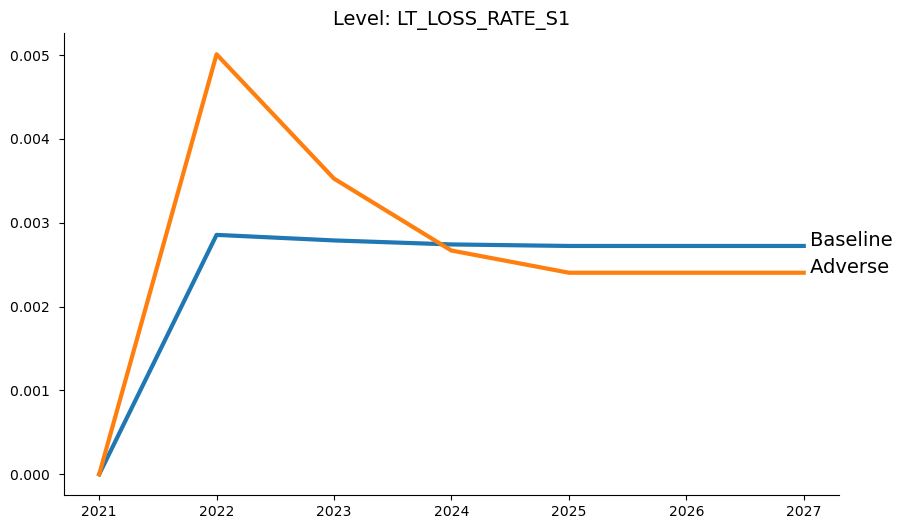

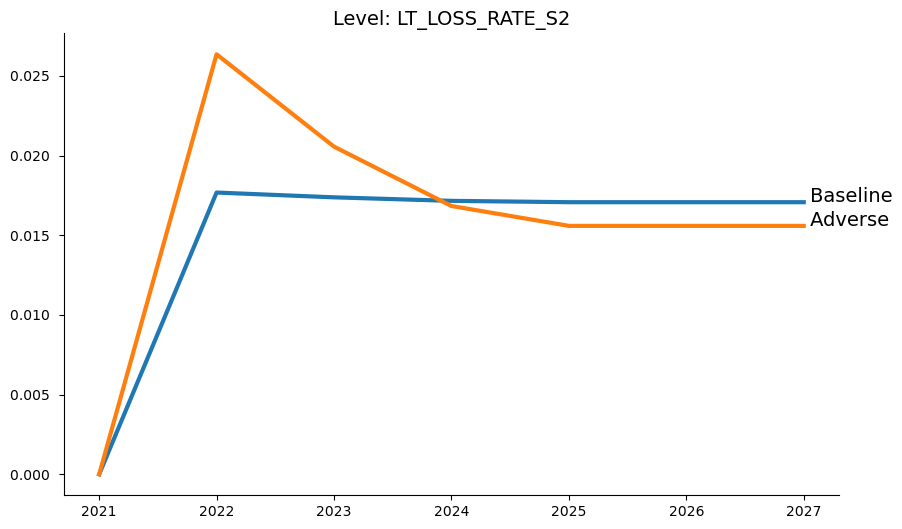

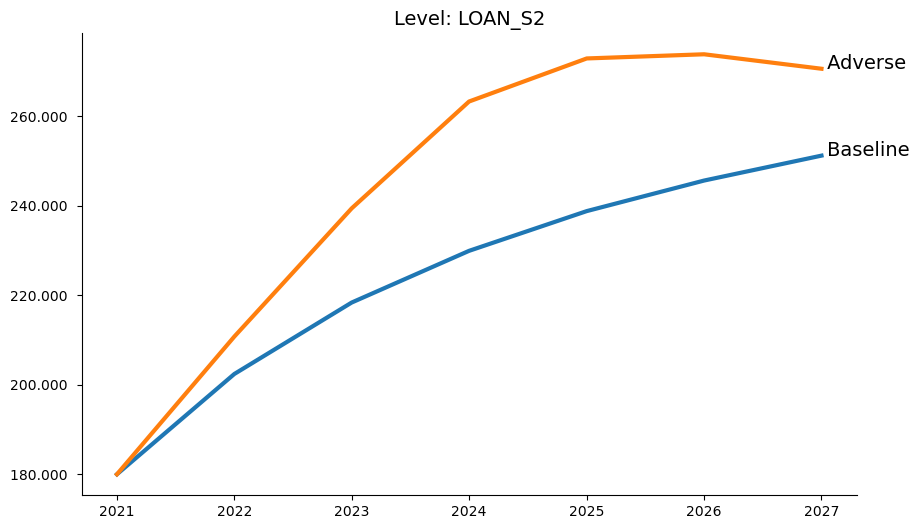

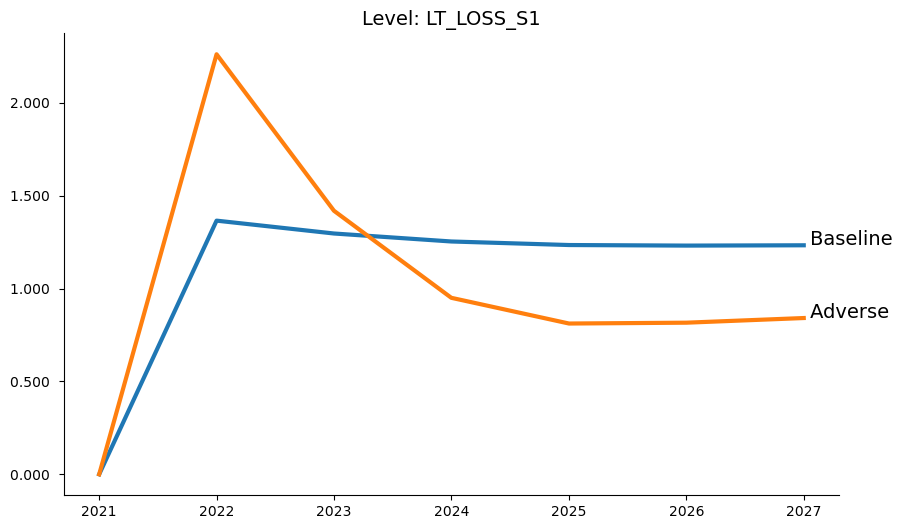

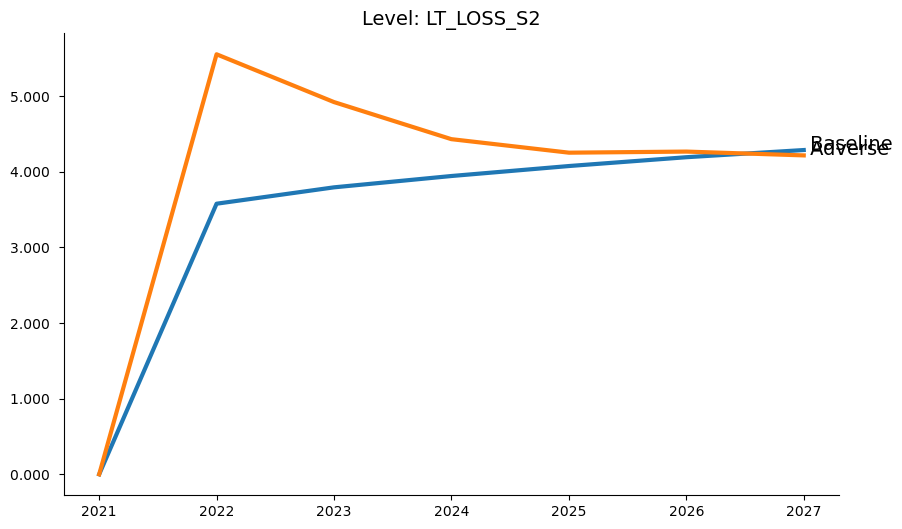

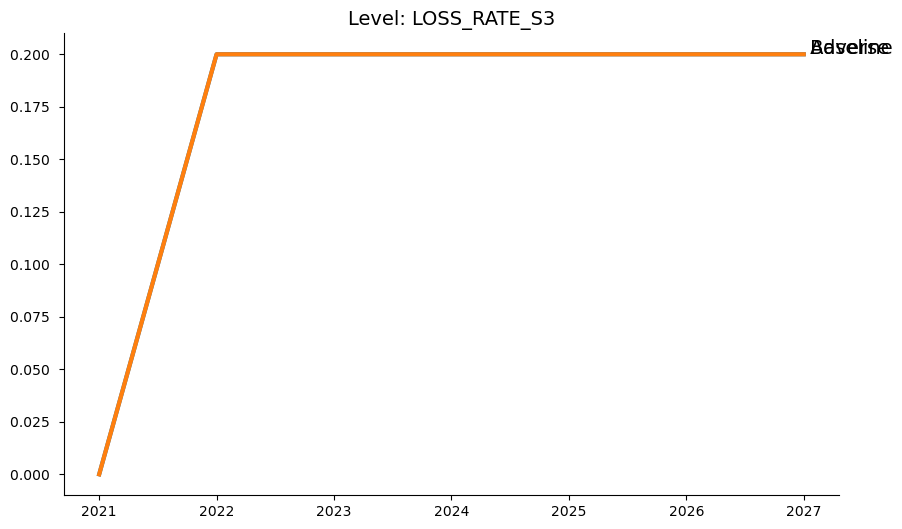

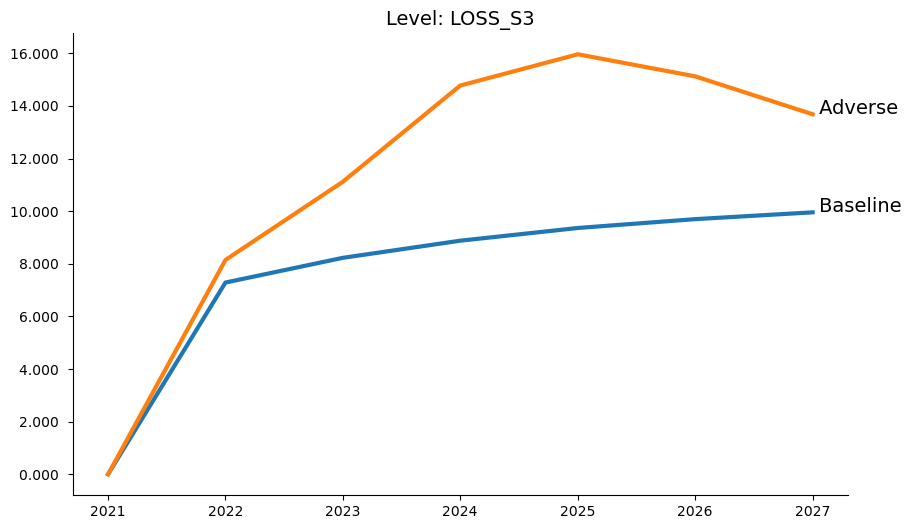

In [13]:
with accounting.set_smpl('2021','2027'):
    accounting.keep_plot('lt_loss_rate* loan_s2 lt_loss* loss_*',legend=0,dec=3);

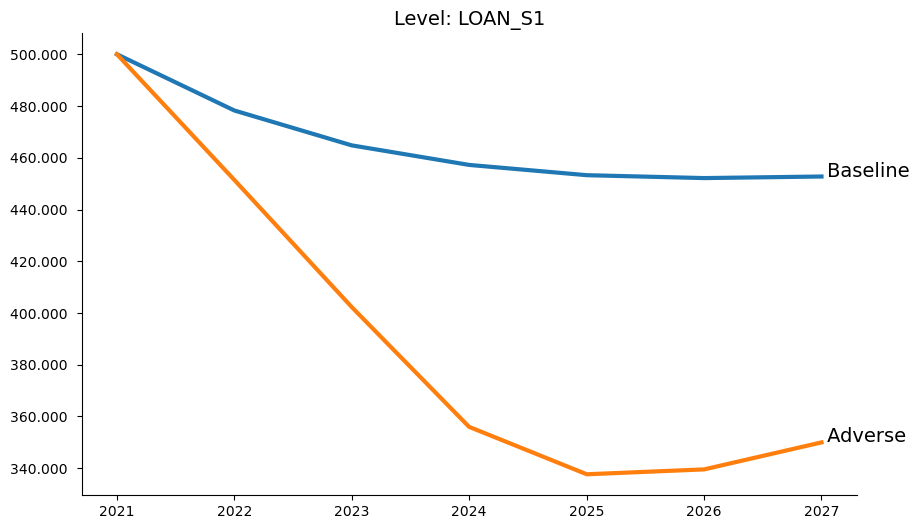

In [14]:
with accounting.set_smpl('2021','2027'):
    accounting.keep_plot('st_loss_rate loan_s1 st_loss',legend=0,dec=3);